<img src="imgs/5_code_description.jpg" alt="Figure 1"
	title="Figure 1" width="45%"/>
    
The 5 Qubit QEC code is described by its stabilizers and logical operators. This QEC code is fault tolerant to `X`,`Z`, and `Y` single qubit flips. [1]

[1] https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.77.198

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister, Aer
import matplotlib.pyplot as plt

In [3]:
data = QuantumRegister(5, name='data')
m = QuantumRegister(4, name='m')
logical = QuantumRegister(1, name="logical")
rounds=2  # The actual number of rounds will always be more than 1, since the first round creates the quiescent state

In [4]:
measurements = []
for i in range(rounds + 1):
    measurements.append(ClassicalRegister(4, name="c{}".format(i+1)))

base_circ = QuantumCircuit(data, m, *measurements, logical)

In [5]:
# [circ.x(i) for i in data]
def stabilize(circ, i):
    # S_1
    circ.h(m[0])
    circ.cx(m[0], data[0])
    circ.cx(m[0], data[3])
    circ.h(m[0])
    circ.cx(data[1],m[0])
    circ.cx(data[2],m[0])
    circ.barrier()
    
    # S_2
    circ.h(m[1])
    circ.cx(m[1], data[1])
    circ.cx(m[1], data[4])
    circ.h(m[1])
    circ.cx(data[2],m[1])
    circ.cx(data[3],m[1])
    circ.barrier()
    
    # S_3
    circ.h(m[2])
    circ.cx(m[2], data[0])
    circ.cx(m[2], data[2])
    circ.h(m[2])
    circ.cx(data[3],m[2])
    circ.cx(data[4],m[2])
    circ.barrier()
    
    # S_4
    circ.h(m[3])
    circ.cx(m[3], data[1])
    circ.cx(m[3], data[3])
    circ.h(m[3])
    circ.cx(data[0],m[3])
    circ.cx(data[4],m[3])
    circ.barrier()
    
    circ.measure(m, measurements[i][:])
    circ.reset(m)
    circ.barrier()

In [6]:
def get_stabilized_circ(base_circuit, rounds):
    circ = base_circuit.copy()
    for i in range(rounds + 1):
        stabilize(circ, i)
    return circ

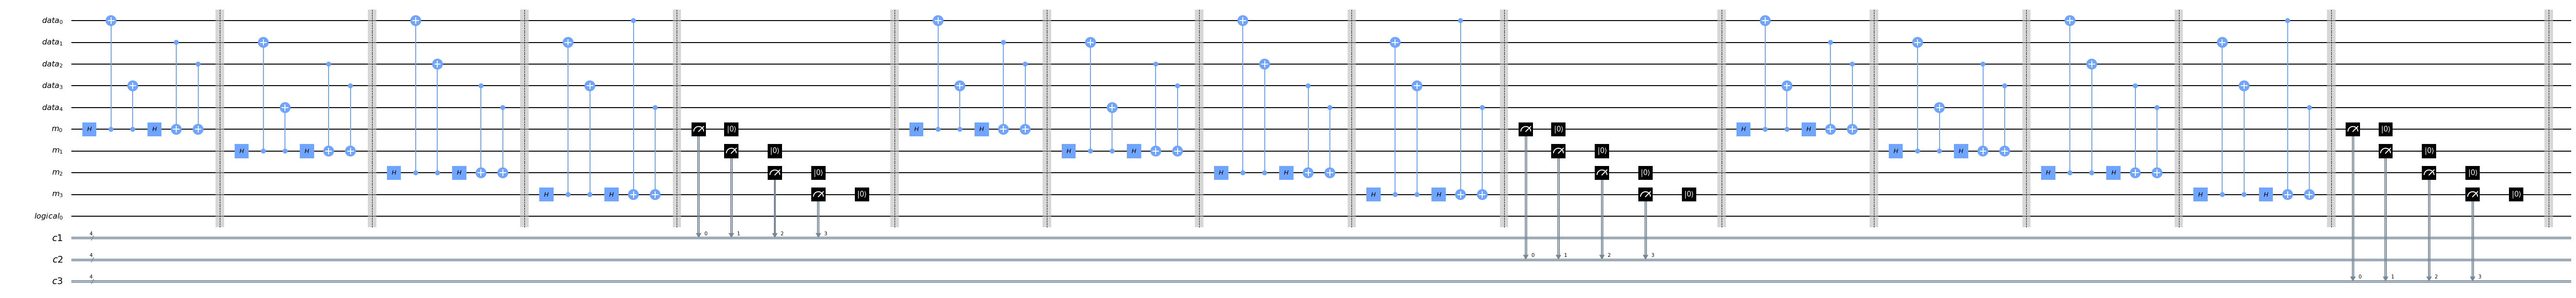

In [7]:
circ = get_stabilized_circ(base_circ, rounds)
circ.draw(output='mpl', fold=150)

Once |00000> is projected into an eigenstate of all the stabilizers, it will remain in that eigenstate under no noise or errors. This is shown by the consistent stabilizer measurements below.

In [8]:
execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

{'1111 1111 1111': 61,
 '1001 1001 1001': 58,
 '0011 0011 0011': 66,
 '0101 0101 0101': 70,
 '1010 1010 1010': 66,
 '0000 0000 0000': 64,
 '0111 0111 0111': 66,
 '0110 0110 0110': 66,
 '1100 1100 1100': 68,
 '0001 0001 0001': 78,
 '1101 1101 1101': 66,
 '1110 1110 1110': 63,
 '1000 1000 1000': 58,
 '0100 0100 0100': 56,
 '1011 1011 1011': 54,
 '0010 0010 0010': 64}

### Inserting a Single Qubit Flip Error

In [9]:
circ = base_circ.copy()
stabilize(circ, 0)

# Insert Y Error on qubit 2 between round 0 and round 1
circ.y(1)

stabilize(circ, 1)
stabilize(circ, 2)

In [10]:
results = execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

In [11]:
def process_result(result):
    processed = ''
    readouts = result.split(" ")
    if len(readouts) <= 1:
        raise Exception("Please enter more than two readouts.")
    for i in range(len(readouts)-1):
        curr = readouts[i]
        old = readouts[i-1]
        xor = int(curr,2) ^ int(old,2)
        xor = '{0:b}'.format(xor)
        if len(xor) < 4:
            xor = '0'*(4-len(xor)) + xor
        processed = xor + ' ' + processed
    return processed[:-1]
        

In [12]:
def process_results(results):
    processed = {}
    for result, count in results.items():
        process = process_result(result)
        if process not in processed:
            processed[process] = 0
        processed[process] += count
    return processed

In [13]:
process_results(results) 
# each XOR string corresponds to 'S4S3S2S1'
# order: 'XOR(round 2 and 1) XOR(round 1 and 0)' 

{'0000 1011': 1024}

As expeceted, stabilizers S4, S2, and S1 were changed between round 0 and round 1, corresponding to a single qubit Y error on qubit 2. This decoding is consistent with the error we inserted. Since there is no error between round 1 and round 2, there is no change in the stabilizer measurements. 